<font size="+3" ><b> <center>Learning XGBoost using Kaggle House Price competition</center></b></font>
>
_**Objectives**_
>
> This is a work in progress, not a polished, complete notebook
>
- Explore Kaggle House Price dataset
- Learn XGBoost
- Learn XGBoost inbuilt k-Fold crossvalidation
- Learn GridsearchCV
- Learn RandomSerchCV
- Learn hyperopt
- Compare model accuracy scores with Kaggle competition submission scores

This is a _long_ Notebook, so care has been taken to use a hierarchy for sections.  Suggestions for how to make this Notebook more user friendly will be much appreciate.
>
_With acknowledgement to [Machine Learning A-Z™: Hands-On Python & R In Data Science](https://www.udemy.com/course/machinelearning/)_
>

# Importing the libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import qgrid  #   To explore Pandas DataFrames like a "spreasheet"
from sklearn.preprocessing import OneHotEncoder
import math
from IPython.core.interactiveshell import InteractiveShell

#  For measuring model performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#  Make sure *all* print() lines are printed, not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Make sure matplotlib charts and graphs are displayed in the cell outputs
%matplotlib inline

# Import and explore the dataset

In [15]:
#   This template assumes the data file contains the dependent (y) variable
#   in the *last column*

#   Load training data
training_data = pd.read_csv('hp_train.csv')  #  Kaggle house price training data
X = training_data.iloc[:, :
                       -1]  #  To get Numpy ndarray add .value.  This gives Pandas DataFrame
y = training_data.iloc[:,
                       -1]  #  To get Numpy ndarray add .value.  This gives Pandas DataFrame

# NB: convert y into type float
y = y.astype(float)  #  This makes y a Pandas Series

#   Load test data for competition
cd = pd.read_csv('hp_test.csv')  #  Kaggle house price test data - the competition data

>*Note*
>
>Categorical features not supported
>
>Note that XGBoost does not provide specialization for categorical features; if your data contains categorical features, load it as a NumPy array first and then perform corresponding preprocessing steps like one-hot encoding.

# Processing the data
>
> With acknowledgement to [Kaggle Notebook by Dominik Gawlik](https://www.kaggle.com/dgawlik/house-prices-eda) for a lot of the techniques used

## Dealing with missing data

XGBoost can automatically handle missing data.  XGBoost was designed to work with sparse data.  However, using k-Nearest Neighbour can, under certain circumstances, beat the built-in function.  _(Acknowledgement to [Massimo Belloni](https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4))_.  This is generally where there is a high number of missing values.  In this Notebook the kNN method is followed for learning purposes.

To outperform the XGBoost built-in default strategy we need two things:

* A distance metric that takes into account missing values [(see this post by AirBnb)](https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba)
* To normalise the dataset to have meaningful distances, obtained by summing up differences among features with different domains (this is not strictly required by XGBoost but it’s needed for kNN imputation)  _**Note:**_ This normalisation should not hurt XGBoost performance - see answer by [Sycorax](https://stats.stackexchange.com/users/22311/sycorax) on [StackExchange](https://stats.stackexchange.com/questions/353462/what-are-the-implications-of-scaling-the-features-to-xgboost)

For resources on using kNN to impute missing values, see posts by:

* [Yohan Obadia](https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637)
* [Kaushik](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)
* [Jason Brownlee](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/)

## Dealing with categorical data
>
>Internally, XGBoost models represent all problems as a regression predictive modeling problem that only takes numerical values as input. If your data is in a different form, it must be prepared into the expected format. See [Data Preparation for Gradient Boosting with XGBoost in Python](https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/)
>
>_**Remember to save the label encoder as a separate object so that we can transform both the training and later the test and validation datasets using the same encoding scheme.**_
>
> >xgboost only deals with numeric columns.

if you have a feature [a,b,b,c] which describes a categorical variable (i.e. no numeric relationship)

Using LabelEncoder you will simply have this:

array([0, 1, 1, 2])
Xgboost will wrongly interpret this feature as having a numeric relationship! This just maps each string ('a','b','c') to an integer, nothing more.

Proper way

Using OneHotEncoder you will eventually get to this:

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
This is the proper representation of a categorical variable for xgboost or any other machine learning tool.

Pandas get_dummies is a nice tool for creating dummy variables (which is easier to use, in my opinion).

One suggestion of code:
>ONE_HOT_COLS = ["categorical_col1", "categorical_col2", "categorical_col3"]
print("Starting DF shape: %d, %d" % df.shape)


for col in ONE_HOT_COLS:
    s = df[col].unique()

    # Create a One Hot Dataframe with 1 row for each unique value
    one_hot_df = pd.get_dummies(s, prefix='%s_' % col)
    one_hot_df[col] = s

    print("Adding One Hot values for %s (the column has %d unique values)" % (col, len(s)))
    pre_len = len(df)

    # Merge the one hot columns
    df = df.merge(one_hot_df, on=[col], how="left")
    assert len(df) == pre_len
    print(df.shape)

### OneHotEncode Categorical Data
>
[Article on encoding categorical data](https://www.datacamp.com/community/tutorials/categorical-data) - used as inspiration for this code

In [16]:
# From https://stackoverflow.com/questions/39923927/pandas-sklearn-one-hot-encoding-dataframe-or-numpy

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [17]:
columns_to_encode = np.where(X.dtypes != np.float)[0]  # List of categorical features indices, int64

list_to_encode = X.columns[columns_to_encode].tolist() # Need a list format


In [18]:
X_enc = pd.get_dummies(data=X, columns=list_to_encode).copy()
cd_enc = pd.get_dummies(data=cd, columns=list_to_encode).copy() # What you do to the training set, do to the competition set


# Splitting the dataset into the Training set and Test set

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_enc, # Using the **encoded** set of features
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

<div class="alert alert-block alert-warning">  

_**Now everything is done up to X_train, X_test, y_train, y_test**_

We are now in familiar territory  
>
</div>

# Training XGBoost on the Training set - baseline model


In [28]:
import xgboost as xgb

params = {
    'booster':  'gbtree', #  The default, outperforms gblinear
    'objective': 'reg:squarederror', # 'reg:linear' is deprecated
    'learning_rate': 0.3,
    'n_estimators': 1000, 
    'eval_metric': 'rmse'
}

xgb_reg = xgb.XGBRegressor(**params)

xgb_reg.fit(X_train,y_train)

y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

RMSE: 40492.682587


R^2: 0.762570




> This vanilla baseline model gives:
> 
>RMSE: 40492.682587  
>R^2: 0.762570

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

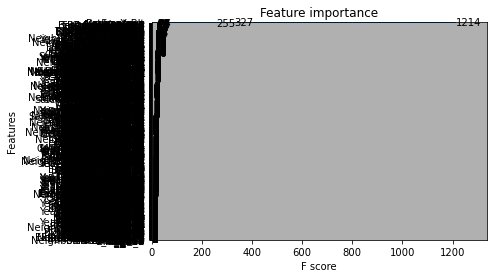

In [42]:
xgb.plot_importance(xgb_reg)
plt.show()

Nice idea, but useless with so many variables

# Using in-built XGBoost.cv()  

<TL;DR>  

>_**I think this is a useless exercise, wasting time.  I can't see the value of .cv()**_ 

https://stackoverflow.com/questions/45892211/xgboost-cv-and-number-of-trees  

https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance  

<br>
XGBoost.cv partitions your training data into two subsets. The first subset is used to train xgboost, the second is used as a validation set. After each iteration (which adds an additional tree) xgboost calculates the new validation error. With that xgboost is able to detect when it starts to overfit (when the validation error starts to increase). This will give you the optimal number of trees for a given set of hyperparameters.  
<br>
**Note that the xgboost.cv returns an evaluation history (a list), whereas xgboost.train returns a booster.**  
<br>
>_**And as a final note: You don't need xgboost.cv to find the optimal number of trees. You can also run xgboost.train with "early_stopping_rounds" set.**_  
<br>
 


<pre>

Python xgb.cv or xgb.evals_result_ returns a dictionary of all 
metrics during training and validating iterations. You can use 
them to plot them and see when they are over-fitting.
</pre>


In [39]:
from xgboost import cv

# Convert dataset to special XGBoost optimised data structure
dtrain_matrix = xgb.DMatrix(X_enc, label=y)
dcomp_matrix = xgb.DMatrix(cd_enc)

# List of parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.3,
#    'max_depth': ,
#    'n_estimators': ,
#    'colsample_bytree': ,
#    'min_child_weight': ,
#    'subsample': ,
#    'eta': ,
#    'eval_metric': 'rmse',
}

# Fit the model
xgb_cv = xgb.cv(
  params = params,
  dtrain = dtrain_matrix,
  num_boost_round=1000,  # Maximum iterations
  nfold=5, # Number of folds to use
  metrics = 'rmse', # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
  as_pandas = True,
  seed = 42,
  early_stopping_rounds = 10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
)

xgb_cv.head()
xgb_cv.tail()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,142181.234375,615.728028,142509.225000,2265.751944
1,103571.134375,532.640031,105511.150000,2577.497965
2,76574.451562,491.421465,79636.328125,2284.805434
3,57637.691407,405.679557,63547.897656,2329.275845
4,44458.595313,432.445503,52718.261719,2649.531761


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
38,9738.812891,326.350683,34361.050391,3629.785920
39,9665.463281,331.186819,34349.745312,3649.558322
40,9590.335742,339.981392,34362.888281,3654.297891
41,9492.865234,319.775938,34335.233985,3672.341068
42,9408.276953,305.734413,34333.874610,3666.856263


>_**This 'cv()' gives a better result, but I have no idea how to get the best model out**_

Text(0, 0.5, 'RMSE')

Text(0.5, 0, 'Round')

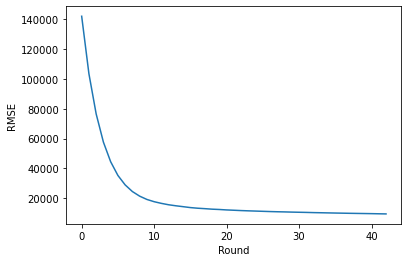

In [40]:
plt.plot(xgb_cv.iloc[:,0])
plt.ylabel("RMSE")
plt.xlabel('Round')


Great, now we can see the number_boost_round that would give best tradeoff between RMSE and training effort.  I really don't see how this is useful if you can just use early_stopping_rounds

# Hyperopt
From here: https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e


fmin() is the main function in hyperopt for optimization. 
It accepts four basic arguments and output the optimized parameter set:
* Objective Function — fn
* Search Space — space
* Search Algorithm — algo
* (Maximum) no. of evaluations — max_evals

We may also pass a Trials object to the trials argument which keeps track of the whole process. In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively. The interim values could be extracted by the following:
* trials.trials - a list of dictionaries contains all relevant information
* trials.results - a list of dictionaries collecting the function outputs
* trials.losses() - a list of losses (float for each 'ok' trial)
* trials.statuses() - a list of status strings
* trials.vals - a dictionary of sampled parameters



In [46]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

###############################################################
#
#   Need to compare the output with the "manual" result above.  A vanilla model gave 40,492, cv() suggests at least 34,333 is possible
#
###############################################################

# Choose hyperparameter domain to search over
# Using parameter list from https://xgboost.readthedocs.io/en/latest/parameter.html

space = {
    'booster': 'gbtree', # This is the default.  Actually no need to define other than for my learning
    'verbosity': 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
    'max_depth': hp.choice('max_depth', np.arange(5, 30, 5, dtype=int)), # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist)
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 200, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.3), # colsample_bytree, colsample_bylevel, colsample_bynode [default=1]. This is a family of parameters for subsampling of columns. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.  All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 500, 50, dtype=int)), # Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.  range: [0,∞]
    'subsample': hp.quniform('subsample', 0.1, 1, 0.3), # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, and this will prevent overfitting. Subsampling will occur once in every boosting iteration.  range: (0,1]
    'gamma': hp.quniform('gamma', 0, 100, 20), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.  Range is [0,∞]
    'eta': hp.quniform('eta', 0.1, 0.6, 0.2),# alias: learning_rate.  Default is 0.3.  Range is [0,1]. Step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    'objective': 'reg:squarederror',
    'lambda': hp.quniform('lambda', 0, 100, 20), # L2 regularization term on weights. Increasing this value will make model more conservative.
    'alpha': hp.quniform('alpha', 0, 100, 20), # L1 regularization term on weights. Increasing this value will make model more conservative.
    'eval_metric': 'rmse',
}

We may also pass a Trials object to the trials argument which keeps track of the whole process. In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively. The interim values could be extracted by the following:

* trials.trials - a list of dictionaries contains all relevant information
* trials.results - a list of dictionaries collecting the function outputs
* trials.losses() - a list of losses (float for each 'ok' trial)
* trials.statuses() - a list of status strings
* trials.vals - a dictionary of sampled parameters

# Learning to write an objective function to use in hyperopt

In [68]:
# Define the function hyperopt must optimise
def objective(params, X_train_matrix, X_test_matrix, y_test):
    num_round = int(params['n_estimators'])
    xgb_reg = xgb.train(params, X_train_matrix, num_round)
    y_pred = xgb_reg.predict(X_test_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

space = {
    'booster':  'gbtree', #  The default, outperforms gblinear
    'objective': 'reg:squarederror', # 'reg:linear' is deprecated
    'learning_rate': 0.3,
    'n_estimators': 1000, 
    'eval_metric': 'rmse'
}
X_train_matrix = xgb.DMatrix(X_train, label=y_train)
X_test_matrix = xgb.DMatrix(X_test)

objective(space, X_train_matrix, X_test_matrix, y_test)


RMSE:  40492.6825867501  



40492.6825867501

Testing this function with the same data as used for the baseline model gives the same RMSE, so I'm comfortable the function works as expected.

# Now using the objective function in actual hyperopt optimiser

First a version to experiment with

In [88]:
# Define the function hyperopt must optimise
# Note: for objective fn with multidimensional optimisation, see here: http://jaberg.github.io/hyperopt/
def objective(params):
    num_round = int(params['n_estimators'])
    xgb_reg = xgb.train(params, X_train_matrix, num_round)
    y_pred = xgb_reg.predict(X_test_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Make DMatrix for calling function, to optimise speed of training
X_train_matrix = xgb.DMatrix(X_train, label=y_train)
X_test_matrix = xgb.DMatrix(X_test)

# Define optimisation space
space = {
    'verbosity': 0, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 

    'n_estimators': hp.choice('n_estimators', [1, 2, 3]),

    'learning_rate': hp.choice('learning_rate', [0.1, 0.3, 0.4]),# alias: eta.  Default is 0.3.  Range is [0,1]. Step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'X_train_matrix': X_train_matrix, 
    'X_test_matrix': X_test_matrix, 
    'y_test': y_test
}

l
# Run hyperopt optimization
trials = Trials()
best = fmin(
    fn=objective,  # objective function
    space=space,   # parameter space
    algo=tpe.suggest,  # surrogate algorithm
    max_evals=10,  # no. of evaluations
    trials=trials  # trials object that keeps track of the sample results (optional).  In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively.
)

# Print the optimized parameters
print("Best = ", best)   


100%|██████████| 10/10 [00:04<00:00,  2.48trial/s, best loss: 66619.5162068994]
Best =  {'learning_rate': 2, 'n_estimators': 2}


In [89]:
# trials.trials - a list of dictionaries contains all relevant information
# trials.results - a list of dictionaries collecting the function outputs
# trials.losses() - a list of losses (float for each 'ok' trial)
# trials.statuses() - a list of status strings
# trials.vals - a dictionary of sampled parameters
trials.vals
# Extract and plot the trials 
# x = trials.vals['x']
# y = [x['loss'] for x in trials.results]
# plt.scatter(x, y)

{'learning_rate': [2, 1, 1, 2, 2, 2, 0, 0, 1, 0],
 'n_estimators': [1, 1, 0, 1, 2, 1, 2, 1, 2, 0]}

Now the real optimisation

In [92]:
# Define the function hyperopt must optimise
def objective(params):
    num_round = int(params['n_estimators'])
    xgb_reg = xgb.train(params, X_train_matrix, num_round)
    y_pred = xgb_reg.predict(X_test_matrix)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Make DMatrix for calling function, to optimise speed of training
X_train_matrix = xgb.DMatrix(X_train, label=y_train)
X_test_matrix = xgb.DMatrix(X_test)

# Define optimisation space
space = {
    'verbosity': 0, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
    'max_depth': hp.choice('max_depth', np.arange(4, 10, 1, dtype=int)), # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist)
    'n_estimators': hp.choice('n_estimators', np.arange(5, 50, 1, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 0.7, 0.05), # colsample_bytree, colsample_bylevel, colsample_bynode [default=1]. This is a family of parameters for subsampling of columns. colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.  All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 5, 1, dtype=int)), # Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.  range: [0,∞]
    'subsample': hp.quniform('subsample', 0.3, 1, 0.05), # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, and this will prevent overfitting. Subsampling will occur once in every boosting iteration.  range: (0,1]
    'gamma': hp.quniform('gamma', 140, 180, 2), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.  Range is [0,∞]
    'learning_rate': hp.quniform('learning_rate', 0.1, 0.6, 0.05),# alias: eta.  Default is 0.3.  Range is [0,1]. Step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    'objective': 'reg:squarederror',
    'lambda': hp.quniform('lambda', 10, 20, 1), # L2 regularization term on weights. Increasing this value will make model more conservative.
    'alpha': hp.quniform('alpha', 50, 60, 1), # L1 regularization term on weights. Increasing this value will make model more conservative.
    'eval_metric': 'rmse',
    'X_train_matrix': X_train_matrix, 
    'X_test_matrix': X_test_matrix, 
    'y_test': y_test
}

# Run hyperopt optimization
trials = Trials()
best = fmin(
    fn=objective,  # objective function
    space=space,   # parameter space
    algo=tpe.suggest,  # surrogate algorithm
    max_evals=2000,  # no. of evaluations
    trials=trials  # trials object that keeps track of the sample results (optional).  In order to run with trails the output of the objective function has to be a dictionary including at least the keys 'loss' and 'status' which contain the result and the optimization status respectively.
)

# Print the optimized parameters
print("Best = ", best)   



100%|██████████| 2000/2000 [1:27:07<00:00,  2.61s/trial, best loss: 34356.15269313811]
Best =  {'alpha': 55.0, 'colsample_bytree': 0.7000000000000001, 'gamma': 154.0, 'lambda': 12.0, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 41, 'subsample': 0.9500000000000001}


Better than before, but disappointingly little improvement

best loss: 34356.15269313811]
Best =  {'alpha': 55.0, 'colsample_bytree': 0.7000000000000001, 'gamma': 154.0, 'lambda': 12.0, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 41, 'subsample': 0.9500000000000001}

# Now train final model with optimised parameters

In [95]:
params = {'alpha': 55.0, 'colsample_bytree': 0.7000000000000001, 'gamma': 154.0, 'lambda': 12.0, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 41, 'subsample': 0.9500000000000001}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))



RMSE: 42075.146410


R^2: 0.743650




In [ ]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [ ]:
# https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test  = X_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.X_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(X_train, X_test, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

#  See how good the models are:

# XGBoost
y_pred = xgb_opt.predict(y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost\n")
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))

# LightGBM
y_pred = lgb_opt.predict(y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("LGB\n")
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))

# CatBoost
y_pred = ctb_opt.predict(y_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("CatBoost\n")
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))

In [ ]:
type(xgb_opt)

xgb_opt[0]
# lgb_opt
# ctb_opt

In [ ]:

#######################################
# Now train model with the "ideal" parameters
#####################################


#   Specify parameters

evallist = [(dtest, 'eval'), (dtrain, 'train')]

evals_result = {}

params = {
    'booster': 'gbtree', # gbtree beats gblinear - don't feel forced to fit linear to this dataset
    'objective': 'reg:squarederror',
#    'colsample_bytree': 3,
    'max_depth': 4,
    'min_child_weight': 3,
    'subsample': 0.9376570860012425,
    'learning_rate': 1,
#     'reg_alpha': 0,  #  L1 regularisation
#     'reg_lambda': 0,  # L2 regularisation
    'eval_metric': 'rmse',  # Used by Kaggle house price competition - this parameter is used for VALIDATION data
#    'evals': evallist,
    'verbose_eval': 1,  # If integer, value is printed every x boosting stages
    'early_stopping_rounds': 10,
    'verbosity': 1,  # 0 is silent, 3 is debug
}

#  Train the model
num_round = 1000
bst = xgb.train(params, dtrain, num_round, evallist)

# Evaluate how good the model is
y_pred = bst.predict(dtest)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE: %f\n\n" % (rmse))
print("R^2: %f\n\n" % (r2))

In [ ]:
# Define objective function for hyperopt

def objective(params):
    model = xgb(**params)
    num_round=10
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_round,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10
        )
    # model = XGBRegressor(**params)

    # model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
    #           verbose=False, early_stopping_rounds=10)

    # y_pred = model.predict(X_test)
    # score = math.sqrt(mean_squared_error(y_test, y_pred))
    # print('RMSE: {:0.2f}'.format(score))
    # return {'loss': score, 'status': STATUS_OK}


    # num_round = 1000

    


In [ ]:
# Now run the actual pyperopt optimisation

trials = Trials()
best_params = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=2, #  Tune this: maximum no of evaluations
    trials=trials #  trials object that keeps track of the sample results
    )

print(best_params)

# Extract and plot the trials 
x = trials.vals['x']
y = [x['loss'] for x in trials.results]
plt.scatter(x, y)


In [ ]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param[
    'eval_metric'] = 'rmse'  #  This is what the Kaggel house price competition uses to score

#  Instantiate an XGBoost regressor object
xg_reg = xgb(booster='gblinear',
             objective='reg:squarederror',
             colsample_bytree=0.3,
             learning_rate=0.3,
             max_depth=10,
             alpha=0,
             n_estimators=1000,
             eval_metric='rmse')

# num_round = 15
# initial_trees = xgb.train(param, dtrain, num_round)

xg_reg.fit(X_train, y_train)

# dtest = xgb.DMatrix(X_test)
# y_pred = bst.predict(dtest)

y_pred = xg_reg.predict(X_test)

math.sqrt(mean_squared_error(y_test, y_pred))

#model = XGBRegressor(space)

In [ ]:
model.fit(X_train,
          y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False,
          early_stopping_rounds=10)

y_pred = model.predict(X_test)
score = math.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {:0.2f}'.format(score))

In [ ]:
from hyperopt.plotting import main_plot_history
main_plot_history(trials)

In [ ]:
model

In [ ]:
y_pred = model.predict(X_test)
print("R^2\n\n")
r2_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies.mean() * 100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [500, 200]
plt.show()

# Another optimisation effort
From https://towardsdatascience.com/how-to-get-started-on-kaggle-competitions-68b91e3e803a
and https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [ ]:
# parameters to be searched over
param_grid = {
    'model__n_estimators': [10, 50, 100, 200, 400, 600],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__min_child_weight': [0.0001, 0.001, 0.01],
    'model__learning_rate': [0.01, 0.1, 0.5, 1]
}

xg_reg = xgb.XGBRegressor(booster='gblinear',
                          objective='reg:squarederror',
                          colsample_bytree=0.3,
                          learning_rate=0.3,
                          max_depth=10,
                          alpha=0,
                          n_estimators=1000,
                          eval_metric='rmse')

# find the best parameter
kfold = KFold(shuffle=True, random_state=0)
grid_search = GridSearchCV(xg_reg,
                           param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=kfold,
                           n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X, Y)
# timer(start_time) # timing ends here for "start_time" variable

#  Print gridsearch results and save to file
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print(
    '\n Best normalized gini score for %d-fold search with %d parameter combinations:'
    % (folds, param_comb))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('xgb-gridsearchcv-results-01.csv', index=False)

In [ ]:
#  Need to figure out how to extract the optimised model, then run the cells below to test how good it is
######  Looks like it is in "best estimator"

In [ ]:
y_pred = model.predict(X_test)
print("R^2\n\n")
r2_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies.mean() * 100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [500, 200]
plt.show()